<a href="https://colab.research.google.com/github/frankl1/Introduction-to-Tensorflow-for-Deep-Learning/blob/master/forecasting_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x 
except:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


TensorFlow 2.x selected.


In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

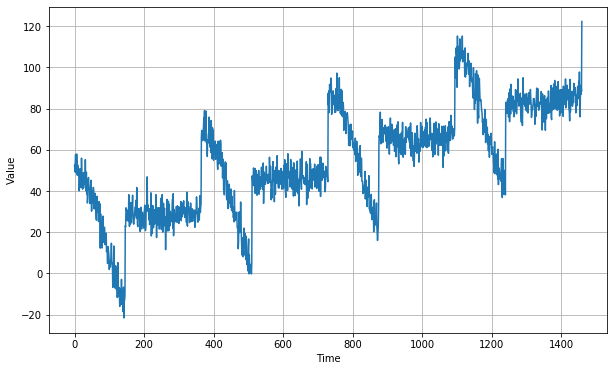

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [0]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
window_size = 30
train_set = window_dataset(x_train, window_size)
val_set = window_dataset(x_valid, window_size)

# Linear model

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, input_shape=[window_size])    
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, validation_data=val_set, epochs=500)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================] - 1s 34ms/step - loss: 12.3733 - mae: 12.9785 - val_loss: 10.6767 - val_mae: 11.2235
Epoch 2/500
31/31 [==============================] - 0s 10ms/step - loss: 11.4563 - mae: 11.9496 - val_loss: 10.8602 - val_mae: 11.3722
Epoch 3/500
31/31 [==============================] - 0s 10ms/step - loss: 10.8793 - mae: 11.3851 - val_loss: 10.0388 - val_mae: 10.4698
Epoch 4/500
31/31 [==============================] - 0s 10ms/step - loss: 10.3122 - mae: 10.8387 - val_loss: 9.4800 - val_mae: 9.8657
Epoch 5/500
31/31 [==============================] - 0s 11ms/step - loss: 9.8925 - mae: 10.3757 - val_loss: 9.34

In [0]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  return model.predict(ds)

In [0]:
linear_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)
linear_forecast = linear_forecast[:, 0]

In [0]:
def plot_forecast(truth, forecast, times):
  mae = tf.keras.metrics.mean_absolute_error(truth, forecast).numpy()
  plt.plot(times, truth, label="Ground truth")
  plt.plot(times, forecast, label="Forecast")
  plt.title(f"MAE={mae}")
  plt.legend()

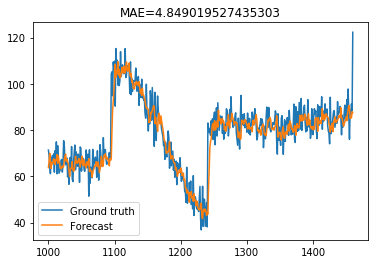

In [0]:
plot_forecast(x_valid, linear_forecast, time_valid)

# Dense model

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=['mae'])
model.summary()

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, validation_data=val_set, epochs=500)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 431
Trainable params: 431
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
31/31 [==============================] - 1s 27ms/step - loss: 12.3087 - mae: 12.9401 - val_loss: 8.8756 - val_mae: 9.3784
Epoch 2/500
31/31 [==============================] - 0s 11ms/step - loss: 9.0199 - mae: 9.5459 - val_loss: 8.6790 - val_mae: 9.0449
Epoch 3/500
31/31 [==============================] - 0s 11ms/step - loss: 8.4780 - mae: 8.9912 - val_loss: 8.1947 - val_

In [0]:
linear_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)
linear_forecast = linear_forecast[:, 0]

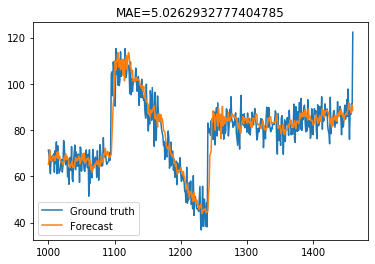

In [0]:
plot_forecast(x_valid, linear_forecast, time_valid)

# Using RNN

In [0]:
rnn_model = tf.keras.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(100, return_sequences=True),
  tf.keras.layers.SimpleRNN(150),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*200.0)
])

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

rnn_model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=["mae"])
rnn_model.fit(train_set, validation_data=val_set, epochs=500, callbacks=[early_stopping, checkpoint])
rnn_model = tf.keras.models.load_model("best_model")

Epoch 1/500
     31/Unknown - 2s 78ms/step - loss: 84.7466 - mae: 85.1605WARNING:tensorflow:From /tensorflow-2.1.0/python3.6/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: best_model/assets
31/31 [==============================] - 5s 176ms/step - loss: 84.7439 - mae: 85.1605 - val_loss: 12.9148 - val_mae: 13.3431
Epoch 2/500
31/31 [==============================] - 3s 110ms/step - loss: 49.0248 - mae: 50.0935 - val_loss: 11.5217 - val_mae: 12.0965
Epoch 3/500
31/31 [==============================] - 1s 34ms/step - loss: 34.1579 - mae: 34.4591 - val_loss: 47.1706 - val_mae: 47.6794
Epoch 4/500
31/31 [==============================] - 1s 34ms/step - loss: 50.5546 - mae: 51.6986 - val_loss: 11.9720 - val_ma

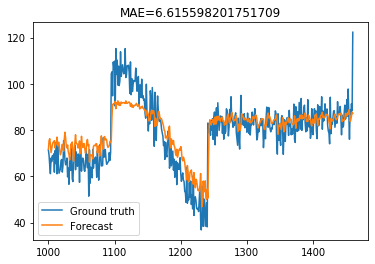

In [0]:
linear_forecast = model_forecast(rnn_model, series[split_time - window_size:-1], window_size)
linear_forecast = linear_forecast[:, 0]
plot_forecast(x_valid, linear_forecast, time_valid)

# Using Sequence to Sequence

In [0]:
def seq2seq_dataset(series, window_size, suffle_buffer=1000, batch_size=32):
  ds = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(ds)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  return ds.shuffle(suffle_buffer).batch(batch_size).prefetch(1)

In [0]:
train_set = seq2seq_dataset(x_train, window_size)
val_set = seq2seq_dataset(x_valid, window_size)

In [0]:
rnn_model_seq2seq = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, input_shape=[None, 1], return_sequences=True),
  tf.keras.layers.SimpleRNN(100, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_seq2seq.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

rnn_model_seq2seq.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=["mae"])
rnn_model_seq2seq.fit(train_set, validation_data=val_set, epochs=500, callbacks=[checkpoint, early_stopping])
rnn_model_seq2seq = tf.keras.models.load_model("rnn_seq2seq.h5")

Epoch 1/500
31/31 [==============================] - 2s 79ms/step - loss: 32.0304 - mae: 32.9041 - val_loss: 14.0406 - val_mae: 14.5605
Epoch 2/500
31/31 [==============================] - 1s 32ms/step - loss: 12.9998 - mae: 13.4434 - val_loss: 13.5298 - val_mae: 14.0463
Epoch 3/500
31/31 [==============================] - 1s 32ms/step - loss: 9.6196 - mae: 10.1996 - val_loss: 7.7571 - val_mae: 8.2823
Epoch 4/500
31/31 [==============================] - 1s 32ms/step - loss: 8.3570 - mae: 8.8299 - val_loss: 6.8622 - val_mae: 7.3632
Epoch 5/500
31/31 [==============================] - 1s 31ms/step - loss: 7.6325 - mae: 8.0914 - val_loss: 7.1866 - val_mae: 7.6285
Epoch 6/500
31/31 [==============================] - 1s 33ms/step - loss: 7.0521 - mae: 7.5276 - val_loss: 6.9010 - val_mae: 7.3868
Epoch 7/500
31/31 [==============================] - 1s 34ms/step - loss: 6.6859 - mae: 7.1547 - val_loss: 6.5223 - val_mae: 6.9793
Epoch 8/500
31/31 [==============================] - 1s 33ms/step -

In [0]:
def seq2seq_forecast(model, series, window_size):
  ds = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(ds)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size))
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  ds = ds.batch(32).prefetch(1)
  return model.predict(ds)

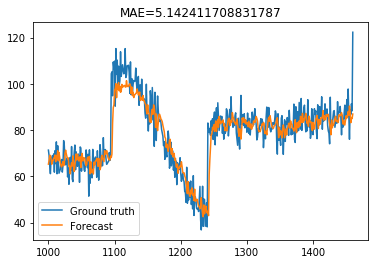

In [0]:
linear_forecast = seq2seq_forecast(rnn_model_seq2seq, series[split_time - window_size:-1], window_size)
linear_forecast = linear_forecast[:, -1, 0]
plot_forecast(x_valid, linear_forecast, time_valid)

# Stateful RNN

In [0]:
def sequential_window_dataset(series, window_size, batch_size=1):
  ds = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(ds)
  ds = ds.window(window_size+1, shift=window_size+1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size+1))
  ds = ds.map(lambda window: (window[:-1], window[1:]))
  return ds.batch(batch_size).prefetch(1)

In [0]:
train_set = sequential_window_dataset(x_train, window_size)
val_set = sequential_window_dataset(x_valid, window_size)

In [0]:
rnn_model_stateful = tf.keras.models.Sequential([
  tf.keras.layers.SimpleRNN(100, batch_input_shape=[1, None, 1], return_sequences=True, stateful=True),
  tf.keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*200.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)

class ResetStateCallback(tf.keras.callbacks.Callback):
  def on_epoch_start(self, epoch, logs):
    self.model.reset_states()

checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_statefull.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

reset_states = ResetStateCallback()

rnn_model_stateful.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=["mae"])
rnn_model_stateful.fit(train_set, validation_data=val_set, epochs=500, callbacks=[checkpoint, early_stopping, reset_states])
rnn_model_stateful = tf.keras.models.load_model("rnn_statefull.h5")

Epoch 1/500
32/32 [==============================] - 2s 62ms/step - loss: 71.3992 - mae: 71.8988 - val_loss: 27.5928 - val_mae: 28.0918
Epoch 2/500
32/32 [==============================] - 0s 15ms/step - loss: 23.6904 - mae: 24.1827 - val_loss: 7.1182 - val_mae: 7.6037
Epoch 3/500
32/32 [==============================] - 0s 14ms/step - loss: 14.4254 - mae: 14.9169 - val_loss: 8.0585 - val_mae: 8.5468
Epoch 4/500
32/32 [==============================] - 0s 15ms/step - loss: 13.2077 - mae: 13.6985 - val_loss: 8.1272 - val_mae: 8.6111
Epoch 5/500
32/32 [==============================] - 0s 15ms/step - loss: 12.6760 - mae: 13.1648 - val_loss: 7.7538 - val_mae: 8.2394
Epoch 6/500
32/32 [==============================] - 0s 15ms/step - loss: 12.3082 - mae: 12.7955 - val_loss: 7.5179 - val_mae: 8.0062
Epoch 7/500
32/32 [==============================] - 0s 16ms/step - loss: 11.9294 - mae: 12.4171 - val_loss: 7.1866 - val_mae: 7.6721
Epoch 8/500
32/32 [==============================] - 0s 15ms

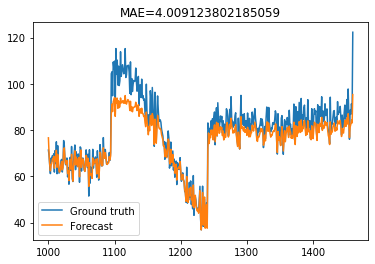

In [0]:
linear_forecast = rnn_model_stateful.predict(x_valid[np.newaxis, :, np.newaxis])
linear_forecast = linear_forecast[0, :, 0]
plot_forecast(x_valid, linear_forecast, time_valid)

# Using LSTMCell

In [0]:
def plot_history(history):
  ncol = 3 if "lr" in history else 2
  ncol = ncol if "val_loss" in history else 1
  i = 1
  plt.figure(figsize=(ncol*6, 5))
  if "lr" in history:
    plt.subplot(1, ncol, i)
    plt.semilogx(history["lr"],history["loss"])
    plt.ylabel("loss")
    plt.xlabel("learning rate")
    i+=1

  if "val_loss" in history:
    plt.subplot(1, ncol, i)
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Val")
    plt.title("Loss")
    plt.legend()
    i+=1

  if "val_mae" in history:
    plt.subplot(1, ncol, i)
    plt.plot(history["mae"], label="Train")
    plt.plot(history["val_mae"], label="Val")
    plt.title("MAE")
    plt.legend()
  

In [0]:
def build_and_train_stateful_rnn(lr=None):
  rnn_model_stateful = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, batch_input_shape=[1, None, 1], return_sequences=True, stateful=True),
    tf.keras.layers.LSTM(100, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200.0)
  ])


  class ResetStateCallback(tf.keras.callbacks.Callback):
    def on_epoch_start(self, epoch, logs):
      self.model.reset_states()

  checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_statefull.h5", save_best_only=True)
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)
  reset_states = ResetStateCallback()

  callbacks=[checkpoint, early_stopping, reset_states]
  if lr is None:
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    callbacks.append(lr_scheduler)
    lr = 1e-8

  optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)

  print("lr:", lr)
  
  rnn_model_stateful.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=["mae"])
  history = rnn_model_stateful.fit(train_set, validation_data=val_set, epochs=500, callbacks=callbacks)
  return tf.keras.models.load_model("rnn_statefull.h5"), history

In [0]:
rnn_model_stateful, history = build_and_train_stateful_rnn()

lr: 1e-08
Epoch 1/500
32/32 [==============================] - 4s 110ms/step - loss: 13.4132 - mae: 13.8992 - val_loss: 35.0762 - val_mae: 35.5760
Epoch 2/500
32/32 [==============================] - 1s 21ms/step - loss: 12.0941 - mae: 12.5811 - val_loss: 33.2768 - val_mae: 33.7732
Epoch 3/500
32/32 [==============================] - 1s 22ms/step - loss: 11.8787 - mae: 12.3650 - val_loss: 32.0911 - val_mae: 32.5875
Epoch 4/500
32/32 [==============================] - 1s 22ms/step - loss: 11.6350 - mae: 12.1234 - val_loss: 30.9742 - val_mae: 31.4726
Epoch 5/500
32/32 [==============================] - 1s 22ms/step - loss: 11.4219 - mae: 11.9117 - val_loss: 29.8742 - val_mae: 30.3742
Epoch 6/500
32/32 [==============================] - 1s 22ms/step - loss: 11.2226 - mae: 11.7144 - val_loss: 28.7437 - val_mae: 29.2418
Epoch 7/500
32/32 [==============================] - 1s 22ms/step - loss: 11.0350 - mae: 11.5256 - val_loss: 27.6169 - val_mae: 28.1165
Epoch 8/500
32/32 [==================

[1e-08, 1.1220185e-08, 1.2589254e-08, 1.41253755e-08, 1.5848931e-08, 1.7782794e-08, 1.9952623e-08, 2.2387212e-08, 2.5118863e-08, 2.8183829e-08, 3.1622776e-08, 3.548134e-08, 3.981072e-08, 4.4668358e-08, 5.011872e-08, 5.6234132e-08, 6.309573e-08, 7.079458e-08, 7.943282e-08, 8.9125095e-08, 1e-07, 1.12201846e-07, 1.2589254e-07, 1.4125375e-07, 1.5848931e-07, 1.7782794e-07, 1.9952623e-07, 2.2387212e-07, 2.5118865e-07, 2.8183828e-07, 3.1622776e-07, 3.5481338e-07, 3.9810718e-07, 4.466836e-07, 5.0118723e-07, 5.623413e-07, 6.3095735e-07, 7.079458e-07, 7.9432823e-07, 8.912509e-07, 1e-06, 1.1220185e-06, 1.2589254e-06, 1.4125376e-06, 1.5848932e-06, 1.7782794e-06, 1.9952622e-06, 2.2387212e-06, 2.5118864e-06]


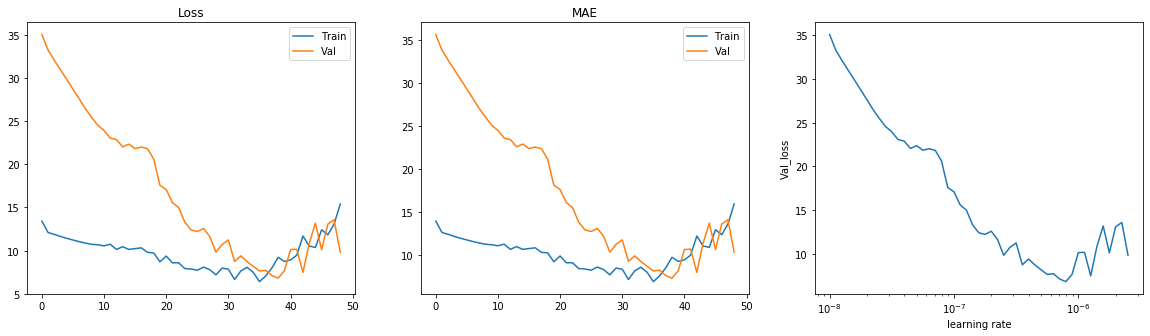

In [0]:
print(history.history["lr"])
plot_history(history.history)

In [0]:
rnn_model_stateful, history = build_and_train_stateful_rnn(history.history["lr"][np.argmin(history.history["loss"])])

lr: 5.623413e-07
Epoch 1/500
32/32 [==============================] - 3s 108ms/step - loss: 28.2916 - mae: 28.7873 - val_loss: 17.6857 - val_mae: 18.1837
Epoch 2/500
32/32 [==============================] - 1s 22ms/step - loss: 9.2535 - mae: 9.7399 - val_loss: 10.0090 - val_mae: 10.5008
Epoch 3/500
32/32 [==============================] - 1s 23ms/step - loss: 8.3751 - mae: 8.8612 - val_loss: 8.4435 - val_mae: 8.9325
Epoch 4/500
32/32 [==============================] - 1s 23ms/step - loss: 7.0533 - mae: 7.5356 - val_loss: 7.6142 - val_mae: 8.1009
Epoch 5/500
32/32 [==============================] - 1s 23ms/step - loss: 6.6850 - mae: 7.1703 - val_loss: 7.3294 - val_mae: 7.8155
Epoch 6/500
32/32 [==============================] - 1s 22ms/step - loss: 6.5523 - mae: 7.0375 - val_loss: 6.9692 - val_mae: 7.4545
Epoch 7/500
32/32 [==============================] - 1s 23ms/step - loss: 6.3754 - mae: 6.8592 - val_loss: 6.7232 - val_mae: 7.2073
Epoch 8/500
32/32 [==============================] -

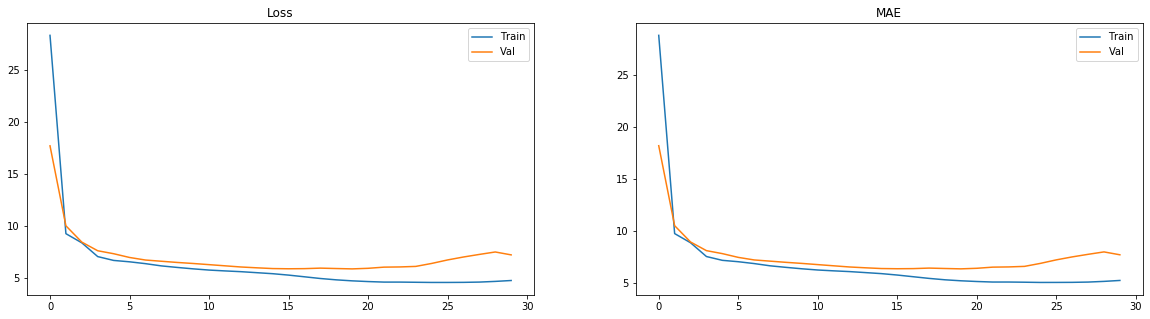

In [0]:
plot_history(history.history)

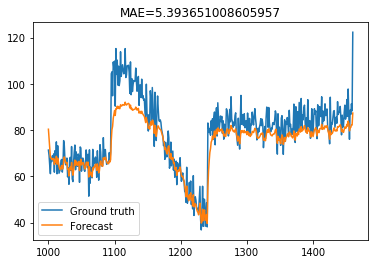

In [0]:
linear_forecast = rnn_model_stateful.predict(x_valid[np.newaxis, :, np.newaxis])
linear_forecast = linear_forecast[0, :, 0]
plot_forecast(x_valid, linear_forecast, time_valid)

# Using Conv1D
## As preprocessor for LSTM

In [0]:
def build_and_train_rnn_conv1d(learning_rate=None):
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32,kernel_size=5, padding="causal", activation="relu", input_shape=[None, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*200.0)
  ])


  checkpoint = tf.keras.callbacks.ModelCheckpoint("rnn_conv1d.h5", save_best_only=True)
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

  callbacks=[]
  if learning_rate is None:
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
    callbacks.append(lr_scheduler)
    lr = 1e-8
  else:
    lr = learning_rate
    callbacks.extend([early_stopping, checkpoint])

  optimizer = tf.keras.optimizers.SGD(lr=lr, momentum=0.9)

  print("lr:", lr)
  
  model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=["mae"])
  history = model.fit(train_set, validation_data=None if learning_rate is None else val_set, epochs=500, callbacks=callbacks)
  return tf.keras.models.load_model("rnn_conv1d.h5"), history

In [0]:
train_set = seq2seq_dataset(x_train, window_size=30, batch_size=128)
val_set = seq2seq_dataset(x_valid, window_size=30, batch_size=128)

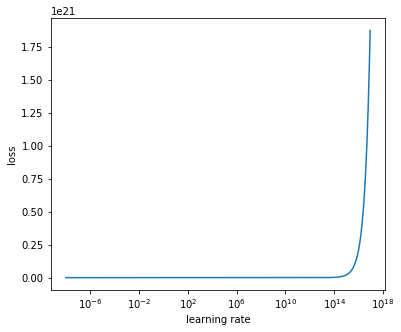

In [76]:
rnn_conv1d_model, history = build_and_train_rnn_conv1d()
plot_history(history.history)

lr: 2.2387212e-05
Epoch 1/500
8/8 [==============================] - 3s 331ms/step - loss: 22.2523 - mae: 23.1283 - val_loss: 36.8728 - val_mae: 37.7001
Epoch 2/500
8/8 [==============================] - 0s 36ms/step - loss: 11.8190 - mae: 12.4141 - val_loss: 26.0335 - val_mae: 26.6858
Epoch 3/500
8/8 [==============================] - 0s 40ms/step - loss: 8.7408 - mae: 9.2646 - val_loss: 15.7518 - val_mae: 16.1901
Epoch 4/500
8/8 [==============================] - 0s 38ms/step - loss: 8.1291 - mae: 8.6357 - val_loss: 13.1216 - val_mae: 13.7161
Epoch 5/500
8/8 [==============================] - 0s 37ms/step - loss: 7.4094 - mae: 7.9100 - val_loss: 14.3600 - val_mae: 14.9560
Epoch 6/500
8/8 [==============================] - 0s 37ms/step - loss: 6.7848 - mae: 7.2574 - val_loss: 13.0679 - val_mae: 13.7030
Epoch 7/500
8/8 [==============================] - 0s 36ms/step - loss: 6.5241 - mae: 6.9860 - val_loss: 12.3008 - val_mae: 12.9686
Epoch 8/500
8/8 [==============================] - 0s

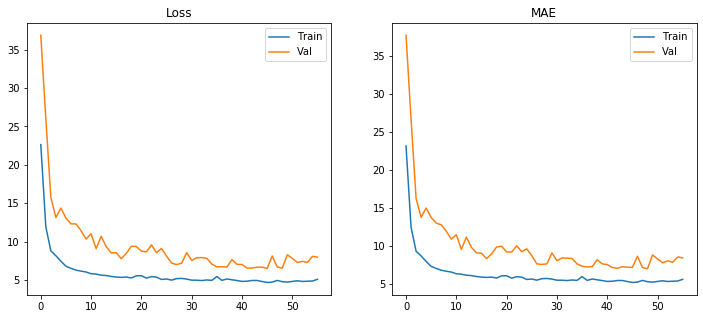

In [77]:
rnn_conv1d_model, history = build_and_train_rnn_conv1d(history.history["lr"][np.argmin(history.history["loss"])])
plot_history(history.history)

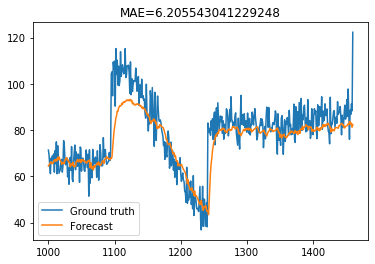

In [79]:
linear_forecast = seq2seq_forecast(rnn_conv1d_model, series[split_time - window_size:-1], window_size)
linear_forecast = linear_forecast[:, -1, 0]
plot_forecast(x_valid, linear_forecast, time_valid)

## Fully conv: Wavenet

In [0]:
def build_and_train_wavenet(learning_rate=None):
  model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[None, 1])
  ])

  dilation_factors = [2**i for i in range(6)]
  for d in dilation_factors:
    model.add(tf.keras.layers.Conv1D(32, 2, padding="causal", dilation_rate=d, activation="relu"))
  model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))

  checkpoint = tf.keras.callbacks.ModelCheckpoint("wavenet.h5", save_best_only=True)
  early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

  callbacks=[]
  if learning_rate is None:
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 30))
    callbacks.append(lr_scheduler)
    lr = 1e-4
  else :
    lr = learning_rate
    callbacks.extend([early_stopping, checkpoint])

  optimizer = tf.keras.optimizers.Adam(lr=lr)

  print("lr:", lr)
  
  model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(), metrics=["mae"])
  model.summary()
  history = model.fit(train_set, validation_data=None if learning_rate is None else val_set, epochs=500, callbacks=callbacks)

  if learning_rate is None:
    return _, history
    
  return tf.keras.models.load_model("wavenet.h5"), history

In [0]:
train_set = seq2seq_dataset(x_train, window_size=64, batch_size=128)
val_set = seq2seq_dataset(x_valid, window_size=64, batch_size=128)

lr: 0.0001
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, None, 32)          96        
_________________________________________________________________
conv1d_50 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_51 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_52 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_53 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_54 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_55 (Conv1D)           (None, None, 

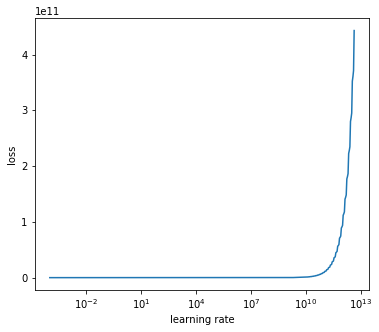

In [89]:
wavenet_model, history = build_and_train_wavenet()
plot_history(history.history)

lr: 0.0031622776
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_56 (Conv1D)           (None, None, 32)          96        
_________________________________________________________________
conv1d_57 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_58 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_59 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_60 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_61 (Conv1D)           (None, None, 32)          2080      
_________________________________________________________________
conv1d_62 (Conv1D)           (None, 

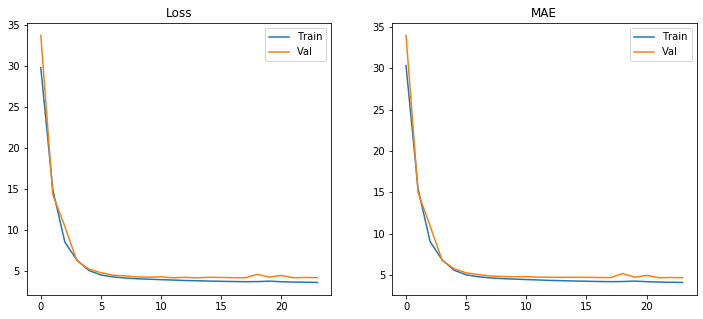

In [90]:
wavenet_model, history = build_and_train_wavenet(history.history["lr"][np.argmin(history.history["loss"])])
plot_history(history.history)

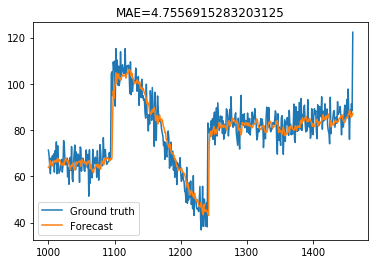

In [91]:
linear_forecast = seq2seq_forecast(wavenet_model, series[split_time - window_size:-1], window_size)
linear_forecast = linear_forecast[:, -1, 0]
plot_forecast(x_valid, linear_forecast, time_valid)